# MiniWoB intro


Mini World of Bits (MiniWoB) is an RL benchmark introduced by OpenAI researchers in 2017.

Their original paper http://proceedings.mlr.press/v70/shi17a/shi17a.pdf

The core idea is to create a set of browser-based tasks to be solved using RL methods. Every task is a small dynamic webpage, which could be interacted using a mouse or keyboard. The reward is given for executing correct sequence of actions. Description of the goal is included into the webpage.

In total it introduced 80 problems of varying complexity -- from the trivial like clicking the form button to very challenging, for example booking the flight following the criterias.

The problems are available here: https://stanfordnlp.github.io/miniwob-plusplus/

Unfortunately, OpenAI discontinued MiniWoB project, so, it hasn't gained popularity it deserves. After OpenAI paper in 2017, MiniWoB was used in several research papers, the most notable ones:

* [1802.08802 Reinforcement Learning on Web Interfaces Using Workflow-Guided Exploration](https://arxiv.org/abs/1802.08802)
* [1812.09195 Learning to Navigate the Web](https://arxiv.org/abs/1812.09195v1)
* [1902.07257v1 DOM-Q-NET: Grounded RL on Structured Language](https://arxiv.org/abs/1902.07257v1)

But that's almost nothing in comparison to Atari games popularity. To fix this mistake, let's play with MiniWoB in this tutorial.

This tutorial uses the original MiniWoB. There exists the imroved version from Stanford researches, called [MiniWoB++](https://stanfordnlp.github.io/miniwob-plusplus/)


## Why that's still relevant for RL

You might ask, why do we need to play with two discontinued projects published two years ago (almost eternity by ML/DL field pace). There are several reasons for that:

* MiniWoB problems are still very far from being solved. 
* Some of them are much harder and much close to real-life human behaviour than Atari games. 
* MiniWoB has practical application in automated software testing, web data extraction and automation.
* Universe with all its issues, allows fast integration of applications into RL experiments without modifying the source code.
* The most important: it's fun!

## Architecture

MiniWoB is implemented as a part of [OpenAI Universe](https://github.com/openai/universe) (another frozen project of OpenAI). The idea of Universe is to use VNC protocol to connect RL agent with GUI applications. As VNC is a cross-platform protocol used by humans to communicate with remote GUI applications, RL agent also achieves this ability (is RL agent smart enough to communicate is a different question). 

MiniWoB is a part of Universe, where GUI app is a browser with loaded dynamic webpages.

Overall architecture of Universe is shown below

![Arch](images/arch.png)

The original MiniWoB docker image is available [on quay.io](https://quay.io/repository/openai/universe.world-of-bits), but I suggest you to use my version with fixed stability issues. The fixed version is available [on dockerhub](https://cloud.docker.com/u/shmuma/repository/docker/shmuma/miniwob). If you want to build your own version of the fixed image, you can follow [instructions here](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/tree/master/Chapter13/wob_fixes)


## Starting the container

If you have docker installed, you can start the single container running the following command:

`docker run -d -p 5900:5900 -p 15900:15900 --privileged --ipc host --cap-add SYS_ADMIN shmuma/miniwob run`

Here, the options:
* `-d` detaches container from terminal and keeps it running in background
* `-p 5900:5900` forwards VNC port to the host machine
* `-p 15900:15900` forwards rewarder port 
* `--privileged` gives extended privileges to this container (not sure is this needed or not, that was written in OpenAI manual)
* `--ipc host` uses host's IPC namespace
* `--cap-add SYS_ADMIN` extends container privileges
* `shmuma/miniwob` name of the container image to start, you can use `quay.io/openai/universe.world-of- bits:0.20.0` to start original MiniWoB image
* `run` command to start inside container

During the training, several containers could be started (to decrease training samples correlation), to simplify this process, this repo includes two scripts: `containers_run.sh` and `containers_stop.sh`. The first starts the required amount of containers (given in command line), the second script stops all started containers (be careful, it just stops ALL containers, not only started by `containers_run.sh` script).

In [1]:
!cat containers_run.sh

#!/usr/bin/env bash
IMAGE_NAME=shmuma/miniwob

count=`docker ps -q | wc -l`

if test $count -ne 0 ; then
    echo You already have $count containers running, are you sure you want more?
    exit
fi

for i in `seq 1 ${1:-1}`; do
    echo Starting container $i
    P1=$((5900+$i-1))
    P2=$((15900+$i-1))
    docker run -d -p $P1:5900 -p $P2:15900 --privileged --ipc host --cap-add SYS_ADMIN $IMAGE_NAME run
done


In [2]:
!cat containers_stop.sh

#!/usr/bin/env bash

docker stop `docker ps -q`


In [358]:
!./containers_run.sh 1

Starting container 1
41526dbe4fca2736a119f98de82fbd476e036c3e1c2fef7582ef11756818a7c0


In [4]:
!docker ps

CONTAINER ID        IMAGE               COMMAND                  CREATED             STATUS                  PORTS                                                        NAMES
e94f531c4888        shmuma/miniwob      "/app/universe-envs/…"   5 seconds ago       Up Less than a second   0.0.0.0:5900->5900/tcp, 5899/tcp, 0.0.0.0:15900->15900/tcp   xenodochial_varahamihira


After this you can connect to the started container using one of many VNC clients available. If you're using MacOS, VNC client is already included in OS, in Finder press `Command+K` and then connect to 'vnc://localhost:5900'. Password for connection is `openai`

![](images/vnc.png)

Do not forget to stop containers, as they are quite CPU-hungry 

In [7]:
!./containers_stop.sh

af325a282347


# Imports

In [1]:
import gym
import ptan
import time
import numpy as np
import universe
from typing import List, Optional, Tuple
from universe import vectorized
from universe.wrappers.experimental import SoftmaxClickMouse

from PIL import Image

/home/shmuma/anaconda3/envs/miniwob/lib/python3.6/site-packages/universe/runtimes/__init__.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  spec = yaml.load(f)


In [2]:
DOCKER_IMAGE = "shmuma/miniwob:latest"

In [3]:
# function to build connection endpoints for set of containers
def remotes_url(port_ofs=0, hostname='localhost', count=8):
    hosts = ["%s:%d+%d" % (hostname, 5900 + ofs, 15900 + ofs) for ofs in range(port_ofs, port_ofs+count)]
    return "vnc://" + ",".join(hosts)

# Gym actions/observations

## Universe vectorized observations/actions

Before we start looking at actual MiniWoB action and observation spaces, we need to state one quite important difference between OpenAI Gym and OpenAI Universe. 

Gym API is **synchronous** in terms of agent's calls to `step()` function and internal environment state. For example, if the agent playing Atari decided to download the 10GB model file (between calls to `step()`), Atari 2600 emulator and the game it emulates notice nothing, as Atari knows nothing about wall clock time, only about ticks of 6507 MCU and internal emulated hardware state. Gym can do this, because it has the full control over every environment it exposes to the developer.

In contrast, Universe has much less knowledge and control over the software it communicates with. VNC protocol provides remote framebuffer interface (low-level name of VNC protocol is RFB), capturing the image on the remote machine and transferring it to VNC client running in front of you. Your actions, like mouse movements and key presses are recorded and being sent to the VNC server. So, VNC is relatively thin protocol providing the impression that remote applications are running locally. This simplifies application integration, but at the same time if you've missed same frame from the input images stream, you've missed it. So, Universe Gym API is **asynchronous**:

* agent needs to be fast enough to process observations and keep the desired framerate. This might be important in cases when something qick is happening on the screen
* on `reset()` call, environment takes some time to start producing observations. To indicate this transient states, it returns None for observations, which means you need to wait and repeat the request.

Another difference is in native support of several environments running in parallel. On creation of environment you can specify how many of them need to be created and system will start several docker images running in parallel. Alternatively, you can provide several ports of already running docker images (possibly on remote machines in the cloud). As a result, Universe `Env` instance returns vectors of observations from `reset()` and `step()` calls and expects you to provide vector of actions for `step()`. This breaks the API, but simplifies the development. 

Ptan library supports both vectorized and old-style environments, which also makes your life a little bit easier. 

## Observations and actions

Universe exposes two new subclasses of Gym `Space` class: [`VNCActionSpace`](https://github.com/openai/universe/blob/master/universe/spaces/vnc_action_space.py) and `VNCObservationSpace`

Action space is a container for `VNCKeyEvent` or `VNCPointerEvent`: https://github.com/openai/universe/blob/master/universe/spaces/vnc_event.py

Observation from single environment is a dictionary with two keys: `vision` with image pixels and `text` with text description from the environment.

In [4]:
!./containers_run.sh 1

You already have 1 containers running, are you sure you want more?


In [10]:
env = gym.make("wob.mini.ClickDialog-v0")
url = remotes_url(count=1)
print(url)

env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=5, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

[2019-06-28 19:39:29,123] Making new env: wob.mini.ClickDialog-v0
/home/shmuma/anaconda3/envs/miniwob/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-06-28 19:39:29,125] Writing logs to file: /tmp/universe-21835.log
[2019-06-28 19:39:29,128] Using the golang VNC implementation
[2019-06-28 19:39:29,129] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-06-28 19:39:29,206] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai


vnc://localhost:5900+15900


In [11]:
while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-06-28 19:39:33,279] Throttle fell behind by 3.87s; lost 19.35 frames
[2019-06-28 19:39:45,636] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-06-28 19:39:46,144] [0:localhost:5900] Initial reset complete: episode_id=11


We've got the first observation. The result is a list of single dict (remember vectorized form of universe observations?) 

In [12]:
obs

[{'vision': array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8), 'text': []}]

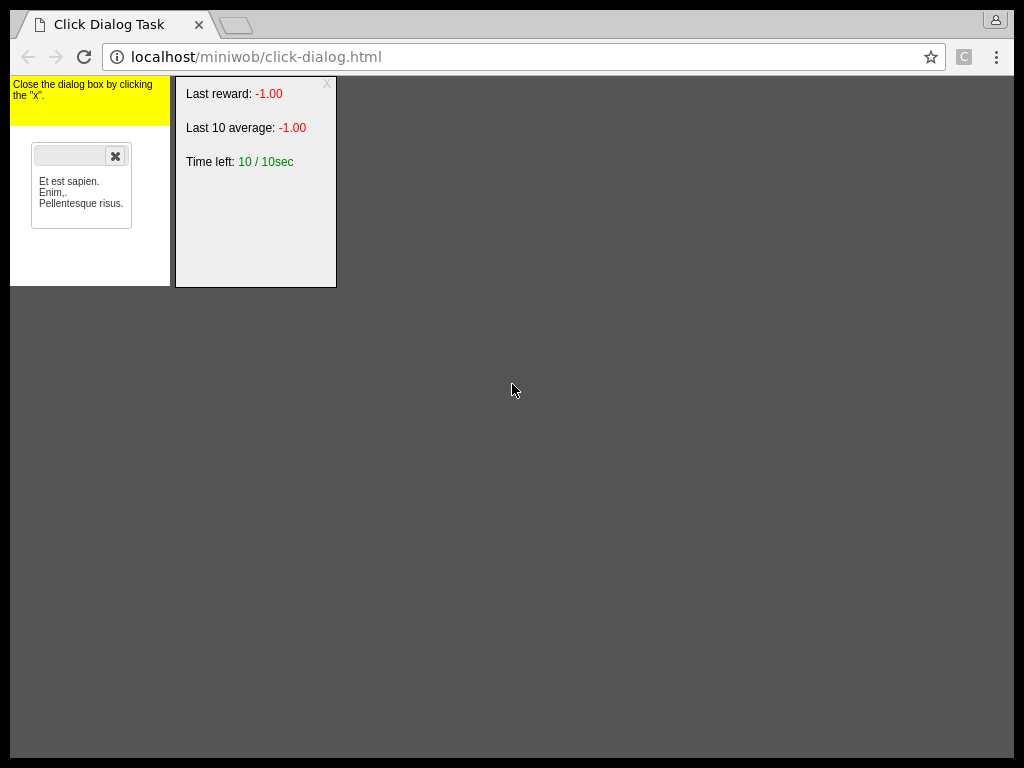

In [13]:
im = Image.fromarray(obs[0]['vision'])
im

### Image cropper

As you can see, image is not cropped which is not very convenient, as relevant part of the problem's field is just tiny portion of the field. Below is the wrapper we'll use to crop the observations

In [5]:
class MiniWoBCropper(vectorized.ObservationWrapper):
    """
    Crops the WoB area and converts the observation into PyTorch (C, H, W) format.
    """
    # Area of interest
    WIDTH = 160
    HEIGHT = 210
    X_OFS = 10
    Y_OFS = 75
    
    def __init__(self, env, keep_text=False):
        super(MiniWoBCropper, self).__init__(env)
        self.keep_text = keep_text
        img_space = gym.spaces.Box(low=0, high=255, shape=(3, self.HEIGHT, self.WIDTH))
        if keep_text:
            self.observation_space = gym.spaces.Tuple(spaces=(img_space, gym.spaces.Space))
        else:
            self.observation_space = img_space

    def _observation(self, observation_n):
        res = []
        for obs in observation_n:
            if obs is None:
                res.append(obs)
                continue
            img = obs['vision'][self.Y_OFS:self.Y_OFS+self.HEIGHT, self.X_OFS:self.X_OFS+self.WIDTH, :]
            img = np.transpose(img, (2, 0, 1))
            if self.keep_text:
                text = " ".join(map(lambda d: d.get('instruction', ''), obs.get('text', [{}])))
                res.append((img, text))
            else:
                res.append(img)
        return res


Tiny easter egg in MiniWoB: image area has exactly the same dimension as Atari games resultion in ALE.

And please note that old gym doesn't support `dtype` in `Box` class, so, it will be wrongly set as float32 (but, in fact, byte)

In [15]:
env = gym.make("wob.mini.ClickDialog-v0")
env = MiniWoBCropper(env)
url = remotes_url(count=1)
print(url)

env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=5, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

[2019-06-28 19:40:13,395] Making new env: wob.mini.ClickDialog-v0
[2019-06-28 19:40:13,410] Using the golang VNC implementation
[2019-06-28 19:40:13,410] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-06-28 19:40:13,433] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai


vnc://localhost:5900+15900


In [16]:
while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-06-28 19:40:15,990] Throttle fell behind by 2.36s; lost 11.78 frames
[2019-06-28 19:40:29,771] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-06-28 19:40:29,797] [0:localhost:5900] Initial reset complete: episode_id=16


In [17]:
obs

[array([[[181, 182, 182, ..., 182, 182, 182],
         [255, 255, 255, ..., 255, 255, 255],
         [254, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],
 
        [[179, 180, 180, ..., 180, 180, 180],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],
 
        [[182, 183, 183, ..., 183, 183, 183],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)]

In [18]:
obs[0].shape

(3, 210, 160)

In [19]:
env.observation_space

Box(3, 210, 160)

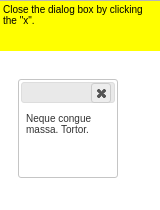

In [20]:
im = Image.fromarray(obs[0].transpose((1, 2, 0)))
im

### Action space

VNCActionSpace can include mouse click and key press events. To demonstrate how it is done, let's solve environment above by using brute force agent (sometimes this approach works better than sophisticated RL methods!)

In [21]:
env.reset()

[2019-06-28 19:41:04,629] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


[None]

In [22]:
while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

In [23]:
# try to solve 10 episodes by doing random clicking
rewards = []
clicks_done = 0

while len(rewards) < 10:
    clicks_done += 1
    click_x = MiniWoBCropper.X_OFS + np.random.randint(MiniWoBCropper.WIDTH)
    click_y = MiniWoBCropper.Y_OFS + np.random.randint(MiniWoBCropper.HEIGHT)

    acts = [
        universe.spaces.PointerEvent(click_x, click_y, buttonmask=0),
        universe.spaces.PointerEvent(click_x, click_y, buttonmask=1),
        universe.spaces.PointerEvent(click_x, click_y, buttonmask=0)
    ]

    obs_n, r_n, end_n, _ = env.step([acts])
    if r_n[0] > 0:
        rewards.append(r_n[0])
        print("Got reward %.3f, clicks done %d" % (r_n[0], clicks_done))
        clicks_done = 0
        
print("Mean reward for %d solved episodes is %.3f" % (len(rewards), np.mean(rewards)))

[2019-06-28 19:41:12,920] Throttle fell behind by 8.09s; lost 40.45 frames


Got reward 0.768, clicks done 106
Got reward 0.771, clicks done 14
Got reward 0.597, clicks done 180
Got reward 0.390, clicks done 33
Got reward 0.971, clicks done 7
Got reward 0.729, clicks done 118
Got reward 0.951, clicks done 5
Got reward 0.079, clicks done 101
Got reward 0.079, clicks done 101
Got reward 0.891, clicks done 8
Mean reward for 10 solved episodes is 0.623


Above approach are sampling from $160*210 = 33600$ action space, which might be too much for RL methods. To simplify our life a bit, we can discretize the area to be clicked by applying some grid and allowing to click only in the center of grid cell.

<img src="images/wob-actions.png" alt="Drawing" style="width: 500px;"/>

Universe already comes with such preprocessor, called `SoftmaxClickMouse`: https://github.com/openai/universe/blob/master/universe/wrappers/experimental/action_space.py#L65, let's try it in our random clicking approach

In [6]:
env = gym.make("wob.mini.ClickDialog-v0")
env = MiniWoBCropper(env)
env = SoftmaxClickMouse(env)
url = remotes_url(count=1)

env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=5, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })

obs = env.reset()


[2019-06-29 12:19:00,985] Making new env: wob.mini.ClickDialog-v0
/home/shmuma/anaconda3/envs/miniwob/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-06-29 12:19:01,000] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-06-29 12:19:01,000] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-06-29 12:19:01,001] Writing logs to file: /tmp/universe-23640.log
[2019-06-29 12:19:01,002] Using the golang VNC implementation
[2019-06-29 12:19:01,002] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-06-29 12:19:01,016] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, su

In [25]:
env.action_space

Discrete(256)

In [26]:
while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-06-28 19:43:41,958] Throttle fell behind by 7.79s; lost 38.97 frames
[2019-06-28 19:43:50,299] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-06-28 19:43:55,371] [0:localhost:5900] Initial reset complete: episode_id=43


In [27]:
# try to solve 10 episodes by doing random clicking
rewards = []
clicks_done = 0

while len(rewards) < 10:
    clicks_done += 1
    act = env.action_space.sample()
    obs_n, r_n, end_n, _ = env.step([act])
    if r_n[0] > 0:
        rewards.append(r_n[0])
        print("Got reward %.3f, clicks done %d" % (r_n[0], clicks_done))
        clicks_done = 0
print("Mean reward for %d solved episodes is %.3f" % (len(rewards), np.mean(rewards)))

[2019-06-28 19:43:59,235] Throttle fell behind by 3.05s; lost 15.27 frames


Got reward 0.735, clicks done 16
Got reward 0.971, clicks done 4
Got reward 0.810, clicks done 12
Got reward 0.391, clicks done 33
Got reward 0.911, clicks done 7
Got reward 0.149, clicks done 45
Got reward 0.399, clicks done 85
Got reward 0.771, clicks done 14
Got reward 0.607, clicks done 232
Got reward 0.250, clicks done 40
Mean reward for 10 solved episodes is 0.599


Not much improvements, probably RL will help with this :).

# Basic DQN baseline

With all those simplifications done, we can implement basic DQN agent to solve some environments.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

[2019-06-29 12:19:17,359] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


## Model 

Below is the model we're going to use. Nothing fancy, just three convolution layers followed by two FC-layers, returning Q-values for our 256 click locations.

In [8]:
class Model(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(Model, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, 5, stride=5),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2),
            nn.ReLU(),
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions),
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        fx = x.float() / 256
        conv_out = self.conv(fx).view(fx.size()[0], -1)
        return self.fc(conv_out)

[2019-06-29 12:19:19,384] [0:localhost:5900] Initial reset complete: episode_id=5807


## Batch preparation (practice)

For data gathering we'll use [`ptan` library](https://github.com/shmuma/ptan/) which is a very thin RL-specific wrapper around Gym. It implement replay buffers, agent logic and other functions frequently required for RL training.

Our first warm-up problem will be to write conversion of batch sampled from Replay Buffer into PyTorch tensors suitable for training.

Input to the function is a list of `namedtuple` with the following fields ([source code](https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L155)):
* `state`: state `s` in the trajectory, which is a 160x210 array of bytes with shape \[3, 210, 160\]
* `action`: action executed, which is an integer from 0 to 255 indicating the square in our click grid
* `reward`: immediate reward obtained after action execution
* `last_state`: state we've got after execution of action. It equals to `None` if episode finished after action.

We'll use 1-step DQN, but Ptan can do N-step calculation for you. You can experiment with the difference.

The output should be three tensors containing the batch data with:
* `state`: in a form of tensor with shape \[X, Y, ...\]
* `actions`: as a long tensor
* `ref values`: approximated Q-values using Bellman equation

$Q_{s,a} = r_{s,a} + \gamma \cdot max_{a'}Q_{s',a'}$


In [ ]:
@torch.no_grad()
def unpack_batch(batch: List[ptan.experience.ExperienceFirstLast], net: nn.Module, gamma: float, device="cpu"):
    states = []
    actions = []
    rewards = []
    done_masks = []    # list of booleans, True if this is the last step in the episode
    last_states = []
    for exp in batch:
        # unpack every experience entry into individual lists
        raise NotImplementedError

    # convert everything to tensors (do not forget to put them into proper devices!)
    # apply network and find best Q values of every action (torch.max() is the right function to use (c: )
    # zero out q-values according to done_masks
    # return the result as tuple of three things: states tensor, actions tensor and 
    # Q-values approximation tensor

### Tests for your solution

There are several test cases you can use to check your solution

In [31]:
# this code also should help you to understand the expectations from your code
net = Model(env.observation_space.shape, env.action_space.n)
# with eps=1, we don't need parent action selector, as all actions will be random, but that's a corner case!
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1) 
agent = ptan.agent.DQNAgent(net, action_selector)
net

Model(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(5, 5))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2016, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [32]:
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=1.0, vectorized=True)
batch = [e for _, e in zip(range(5), exp_source)]
# add one final state with known reward
batch.append(ptan.experience.ExperienceFirstLast(state=batch[0].state, action=0, reward=10.0, last_state=None))

[2019-06-28 19:47:26,524] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


In [33]:
r = unpack_batch(batch, net, gamma=1.0)

In [34]:
assert isinstance(r, tuple)
assert len(r) == 3

In [35]:
states, actions, next_q = r

In [36]:
assert isinstance(states, torch.Tensor)
assert states.dtype == torch.uint8
assert states.size() == (6, 3, 210, 160)

assert isinstance(actions, torch.Tensor)
assert actions.dtype == torch.long
assert actions.size() == (6, )

assert isinstance(next_q, torch.Tensor)
assert next_q.dtype == torch.float32
assert next_q.size() == (6, )

assert actions[5] == 0
assert next_q[5] == 10.0

## Batch preparation (solution)

Please do not peek inside this, as you'll spoil all the fun :)

In [9]:
@torch.no_grad()
def unpack_batch(batch: List[ptan.experience.ExperienceFirstLast], net: nn.Module, gamma: float, device="cpu"):
    states = []
    actions = []
    rewards = []
    done_masks = []
    last_states = []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        done_masks.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)

    states_v = torch.tensor(states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    last_states_v = torch.tensor(last_states).to(device)
    last_state_q_v = net(last_states_v)
    best_last_q_v = torch.max(last_state_q_v, dim=1)[0]
    best_last_q_v[done_masks] = 0.0
    return states_v, actions_v, best_last_q_v + rewards_v

## Training loop

Now we're ready to implement the training loop

In [199]:
GAMMA = 0.9
REPLAY_SIZE = 10000
MIN_REPLAY = 100
TGT_SYNC = 100
BATCH_SIZE = 16
LR = 1e-3
DEVICE = "cuda"  
#DEVICE = "cpu"

INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.2
STEPS_EPSILON = 1000

In [200]:
env = gym.make("wob.mini.ClickDialog-v0")
env = MiniWoBCropper(env)
env = SoftmaxClickMouse(env)
url = remotes_url(count=1)

env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=1, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

[2019-06-30 20:02:10,205] Making new env: wob.mini.ClickDialog-v0
/home/shmuma/anaconda3/envs/miniwob/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-06-30 20:02:10,209] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-06-30 20:02:10,209] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-06-30 20:02:10,210] Using the golang VNC implementation
[2019-06-30 20:02:10,210] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-06-30 20:02:10,229] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC cl

In [201]:
while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-06-30 20:02:26,675] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-06-30 20:02:26,745] [0:localhost:5900] Initial reset complete: episode_id=16745


In [202]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
tgt_net = ptan.agent.TargetNet(net)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=INITIAL_EPSILON, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)
optimizer = optim.Adam(net.parameters(), LR)

In [ ]:
episode_rewards = []
episode_steps = []
losses = []
steps = 0
last_ts = time.time()
last_steps = 0

while True:
    steps += 1
    buffer.populate(1)
    r = exp_source.pop_rewards_steps()
    if r:
        for rw, st in r:
            episode_rewards.append(rw)
            episode_steps.append(st)
        speed = (steps - last_steps) / (time.time() - last_ts)
        print("%d: Done %d episodes, last 100 means: reward=%.3f, steps=%.3f, speed=%.2f steps/s, eps=%.2f" % (
            steps, len(episode_rewards), np.mean(episode_rewards[-100:]), 
            np.mean(episode_steps[-100:]), speed, action_selector.epsilon
        ))
        last_ts = time.time()
        last_steps = steps
        if np.mean(episode_rewards[-100:]) > 0.9:
            print("You solved the env! Congrats!")
            break
    if len(buffer) < MIN_REPLAY:
        continue
    batch = buffer.sample(BATCH_SIZE)
    state_v, actions_v, ref_q_v = unpack_batch(batch, tgt_net.target_model, gamma=GAMMA, device=DEVICE)
    optimizer.zero_grad()
    q_v = net(state_v)
    q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    loss_v = F.mse_loss(q_v, ref_q_v)
    loss_v.backward()
    optimizer.step()
    losses.append(loss_v.item())
    
    if steps % TGT_SYNC == 0:
        print("%d: nets synced, mean loss for last 100 steps = %.3f" % (
            steps, np.mean(losses[-100:])))
        tgt_net.sync()
    action_selector.epsilon = max(FINAL_EPSILON, INITIAL_EPSILON - steps / STEPS_EPSILON)

[2019-06-30 20:02:28,342] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


10: Done 1 episodes, last 100 means: reward=-1.000, steps=11.000, speed=0.71 steps/s, eps=1.00
20: Done 2 episodes, last 100 means: reward=-1.000, steps=10.500, speed=1.00 steps/s, eps=1.00
31: Done 3 episodes, last 100 means: reward=-1.000, steps=10.667, speed=1.00 steps/s, eps=1.00
41: Done 4 episodes, last 100 means: reward=-1.000, steps=10.500, speed=1.00 steps/s, eps=1.00
52: Done 5 episodes, last 100 means: reward=-1.000, steps=10.600, speed=1.00 steps/s, eps=1.00
62: Done 6 episodes, last 100 means: reward=-1.000, steps=10.500, speed=1.00 steps/s, eps=1.00
73: Done 7 episodes, last 100 means: reward=-1.000, steps=10.571, speed=1.00 steps/s, eps=1.00
83: Done 8 episodes, last 100 means: reward=-0.875, steps=10.500, speed=1.00 steps/s, eps=1.00
94: Done 9 episodes, last 100 means: reward=-0.889, steps=10.556, speed=1.00 steps/s, eps=1.00
100: nets synced, mean loss for last 100 steps = 0.063
104: Done 10 episodes, last 100 means: reward=-0.900, steps=10.500, speed=1.00 steps/s, ep

830: Done 83 episodes, last 100 means: reward=-0.808, steps=10.036, speed=1.00 steps/s, eps=0.20
841: Done 84 episodes, last 100 means: reward=-0.799, steps=10.048, speed=1.00 steps/s, eps=0.20
851: Done 85 episodes, last 100 means: reward=-0.813, steps=10.047, speed=1.00 steps/s, eps=0.20
862: Done 86 episodes, last 100 means: reward=-0.815, steps=10.058, speed=1.00 steps/s, eps=0.20
870: Done 87 episodes, last 100 means: reward=-0.803, steps=10.034, speed=1.00 steps/s, eps=0.20
880: Done 88 episodes, last 100 means: reward=-0.805, steps=10.034, speed=1.00 steps/s, eps=0.20
891: Done 89 episodes, last 100 means: reward=-0.807, steps=10.045, speed=1.00 steps/s, eps=0.20
894: Done 90 episodes, last 100 means: reward=-0.790, steps=9.967, speed=1.00 steps/s, eps=0.20
900: nets synced, mean loss for last 100 steps = 0.192
904: Done 91 episodes, last 100 means: reward=-0.792, steps=9.967, speed=1.00 steps/s, eps=0.20
914: Done 92 episodes, last 100 means: reward=-0.794, steps=9.967, speed=1

1620: Done 162 episodes, last 100 means: reward=-0.848, steps=10.090, speed=1.00 steps/s, eps=0.20
1630: Done 163 episodes, last 100 means: reward=-0.848, steps=10.090, speed=1.00 steps/s, eps=0.20
1641: Done 164 episodes, last 100 means: reward=-0.861, steps=10.110, speed=1.00 steps/s, eps=0.20
1651: Done 165 episodes, last 100 means: reward=-0.861, steps=10.110, speed=1.00 steps/s, eps=0.20
1662: Done 166 episodes, last 100 means: reward=-0.861, steps=10.110, speed=1.00 steps/s, eps=0.20
1672: Done 167 episodes, last 100 means: reward=-0.861, steps=10.110, speed=1.00 steps/s, eps=0.20
1683: Done 168 episodes, last 100 means: reward=-0.861, steps=10.110, speed=1.00 steps/s, eps=0.20
1693: Done 169 episodes, last 100 means: reward=-0.861, steps=10.110, speed=1.00 steps/s, eps=0.20
1700: nets synced, mean loss for last 100 steps = 0.810
1704: Done 170 episodes, last 100 means: reward=-0.861, steps=10.110, speed=1.00 steps/s, eps=0.20
1714: Done 171 episodes, last 100 means: reward=-0.86

2417: Done 242 episodes, last 100 means: reward=-0.839, steps=9.990, speed=1.00 steps/s, eps=0.20
2428: Done 243 episodes, last 100 means: reward=-0.839, steps=10.000, speed=1.00 steps/s, eps=0.20
2438: Done 244 episodes, last 100 means: reward=-0.850, steps=10.000, speed=1.00 steps/s, eps=0.20
2449: Done 245 episodes, last 100 means: reward=-0.850, steps=10.010, speed=1.00 steps/s, eps=0.20
2459: Done 246 episodes, last 100 means: reward=-0.850, steps=10.000, speed=1.00 steps/s, eps=0.20
2470: Done 247 episodes, last 100 means: reward=-0.850, steps=10.010, speed=1.00 steps/s, eps=0.20
2480: Done 248 episodes, last 100 means: reward=-0.850, steps=10.000, speed=1.00 steps/s, eps=0.20
2491: Done 249 episodes, last 100 means: reward=-0.850, steps=10.010, speed=1.00 steps/s, eps=0.20
2500: nets synced, mean loss for last 100 steps = 2.827
2501: Done 250 episodes, last 100 means: reward=-0.850, steps=10.000, speed=1.00 steps/s, eps=0.20
2512: Done 251 episodes, last 100 means: reward=-0.840

3207: Done 322 episodes, last 100 means: reward=-0.791, steps=9.920, speed=1.00 steps/s, eps=0.20
3217: Done 323 episodes, last 100 means: reward=-0.801, steps=9.920, speed=1.00 steps/s, eps=0.20
3228: Done 324 episodes, last 100 means: reward=-0.801, steps=9.920, speed=1.00 steps/s, eps=0.20
3238: Done 325 episodes, last 100 means: reward=-0.811, steps=9.920, speed=1.00 steps/s, eps=0.20
3249: Done 326 episodes, last 100 means: reward=-0.811, steps=9.920, speed=1.00 steps/s, eps=0.20
3259: Done 327 episodes, last 100 means: reward=-0.811, steps=9.920, speed=1.00 steps/s, eps=0.20
3268: Done 328 episodes, last 100 means: reward=-0.799, steps=9.900, speed=1.00 steps/s, eps=0.20
3278: Done 329 episodes, last 100 means: reward=-0.799, steps=9.900, speed=1.00 steps/s, eps=0.20
3289: Done 330 episodes, last 100 means: reward=-0.811, steps=9.920, speed=1.00 steps/s, eps=0.20
3299: Done 331 episodes, last 100 means: reward=-0.811, steps=9.920, speed=1.00 steps/s, eps=0.20
3300: nets synced, m

[2019-06-30 21:03:46,037] [0:localhost:5900] Could not recalibrate network: [Failure instance: Traceback (failure with no frames): <class 'universe.error.Error'>: Can't send message to closed connection
]


3666: Done 369 episodes, last 100 means: reward=-0.805, steps=9.850, speed=1.00 steps/s, eps=0.20
3677: Done 370 episodes, last 100 means: reward=-0.805, steps=9.850, speed=1.00 steps/s, eps=0.20
3687: Done 371 episodes, last 100 means: reward=-0.805, steps=9.850, speed=1.00 steps/s, eps=0.20
3698: Done 372 episodes, last 100 means: reward=-0.805, steps=9.850, speed=1.00 steps/s, eps=0.20
3700: nets synced, mean loss for last 100 steps = 6.384
3708: Done 373 episodes, last 100 means: reward=-0.805, steps=9.850, speed=1.00 steps/s, eps=0.20
3719: Done 374 episodes, last 100 means: reward=-0.805, steps=9.850, speed=1.00 steps/s, eps=0.20
3729: Done 375 episodes, last 100 means: reward=-0.805, steps=9.850, speed=1.00 steps/s, eps=0.20
3740: Done 376 episodes, last 100 means: reward=-0.815, steps=9.850, speed=1.00 steps/s, eps=0.20
3750: Done 377 episodes, last 100 means: reward=-0.815, steps=9.850, speed=1.00 steps/s, eps=0.20
3761: Done 378 episodes, last 100 means: reward=-0.831, steps=

# Troubleshooting of Baseline DQN

> "You love Linux, probably you're experienced in troubleshooting..."
> RHCE Exam Instructor @ 2005

Code above doesn't converge. Usually, in such situations, tutorial author tweaks the parameters to make it working, so, attendants see only final, polished version. This makes the false impression of ML as smooth and quite obvious process, which very far from truth. Don't know about others, but my code doesn't work 90% of the time :).

To learn how to deal with such situations, you're asked to troubleshoot the code above. There are several directions you could explore (of course, you can have your own ideas, that's not the complete list):

* check training samples. Do they make sense? Is reward properly assigned to correct observations? Rememer, MiniWoB could have bugs
* training gradients. How large they are? What's the ratio of gradients/weight values?
* do end-of-episode steps handled properly? Final steps of epsiodes act as an anchor to prevent Q values from growing infinitely, so, it is critical to have them properly handled in Bellman equation
* explore Q values produced by the network during the training. Are they growing over time? That's a good practice to have small set of states (including final step and steps before the final) and track their Qs during the training.
* how large the difference between trained network and target net used for next-step Bellman approximation? How it changes over time?

Full check might take a day, especially if you haven't done it before. In separate notebook (01_miniwob_baseline_debug) you will be shown how to do those checks in this environment, but you should try implement them yourself.

## Training samples check

Here we're going to eyeball our training samples. OpenAI Universe is asynchronous, so, if we're missing a frame or have delays to handle input data, we can get weird training samples.

To do this, we implement small `Env` wrapper applied after `MiniWoBCropper` to keep history of training sequences.

In [53]:
import collections
from PIL import Image, ImageDraw
import matplotlib.pylab as plt

%matplotlib inline

In [109]:
class TrajectoryTracking(vectorized.Wrapper):
    """
    Keeps last N trajectories from the environment
    """
    def __init__(self, env, size: int):
        super(TrajectoryTracking, self).__init__(env)
        self.trajectories = collections.deque(maxlen=size)
        self._in_progress = []

    def reset(self):
        obs_n = self.env.reset()
        if not self._in_progress:
            self._in_progress = [[] for _ in obs_n]
        for t, obs in zip(self._in_progress, obs_n):
            if t:
                self.trajectories.append(list(t))
                t.clear()
            if obs:
                t.append(obs)
        return obs_n
    
    def step(self, action_n):
        obs_n, r_n, done_n, info_n = self.env.step(action_n)
        for t, obs, r, act in zip(self._in_progress, obs_n, r_n, action_n):
            t.append((obs, act, r))
        for t, done in zip(self._in_progress, done_n):
            if done:
                self.trajectories.append(list(t))
                t.clear()
        return obs_n, r_n, done_n, info_n

Let's apply it to our training to get trajectories to check

In [127]:
env = gym.make("wob.mini.ClickDialog-v0")
env = MiniWoBCropper(env)
env = SoftmaxClickMouse(env)
env = TrajectoryTracking(env, size=10)
url = remotes_url(count=1)

env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=1, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

[2019-06-29 19:08:39,953] Making new env: wob.mini.ClickDialog-v0
[2019-06-29 19:08:39,956] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-06-29 19:08:39,957] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-06-29 19:08:39,958] Using the golang VNC implementation
[2019-06-29 19:08:39,958] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-06-29 19:08:39,977] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai


In [128]:
while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-06-29 19:08:56,395] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-06-29 19:08:56,431] [0:localhost:5900] Initial reset complete: episode_id=8159


In [129]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=1.0, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)

In [130]:
# populate buffer to get some trajectories
for _ in range(100):
    buffer.populate(1)
    for rw, st in exp_source.pop_rewards_steps():
        print("Episode done with %d steps and %.3f reward" % (st, rw))

[2019-06-29 19:08:57,774] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


Episode done with 14 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and 0.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 2 steps and 0.940 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 2 steps and 0.852 reward
Episode done with 10 steps and 0.050 reward


In [131]:
len(env.trajectories)

10

In [132]:
list(map(len, env.trajectories))

[10, 11, 10, 11, 10, 2, 10, 11, 2, 10]

In [149]:
# you might want to select different trajectory to check, I've chosen not very long one with positive reward
tr = env.trajectories[-1]

In [150]:
tr_obs, tr_act, tr_rw = zip(*tr)

In [151]:
tr_act

(94, 5, 248, 94, 226, 192, 254, 157, 148, 38)

In [152]:
tr_rw

(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05)

In [153]:
def get_obs_img(obs, action=None, action_step_pix=10, action_y_ofs=50, transpose=True):
    """
    Get the image from observation with optional action place shown
    """
    if transpose:
        obs = np.transpose(obs, (1, 2, 0))
    img = Image.fromarray(obs)
    if action is not None:
        draw = ImageDraw.Draw(img)
        if isinstance(action, tuple):
            x_ofs, y_ofs = action
        else:
            y_ofs = action_y_ofs + (action % 16) * action_step_pix
            x_ofs = (action // 16) * action_step_pix
        half_step = action_step_pix//2
        draw.ellipse((x_ofs-half_step, y_ofs-half_step, x_ofs+half_step, y_ofs+half_step),
                     (0, 0, 255, 128))
    return img

In [154]:
imgs = [get_obs_img(obs, action=act) for obs, act in zip(tr_obs, tr_act)]

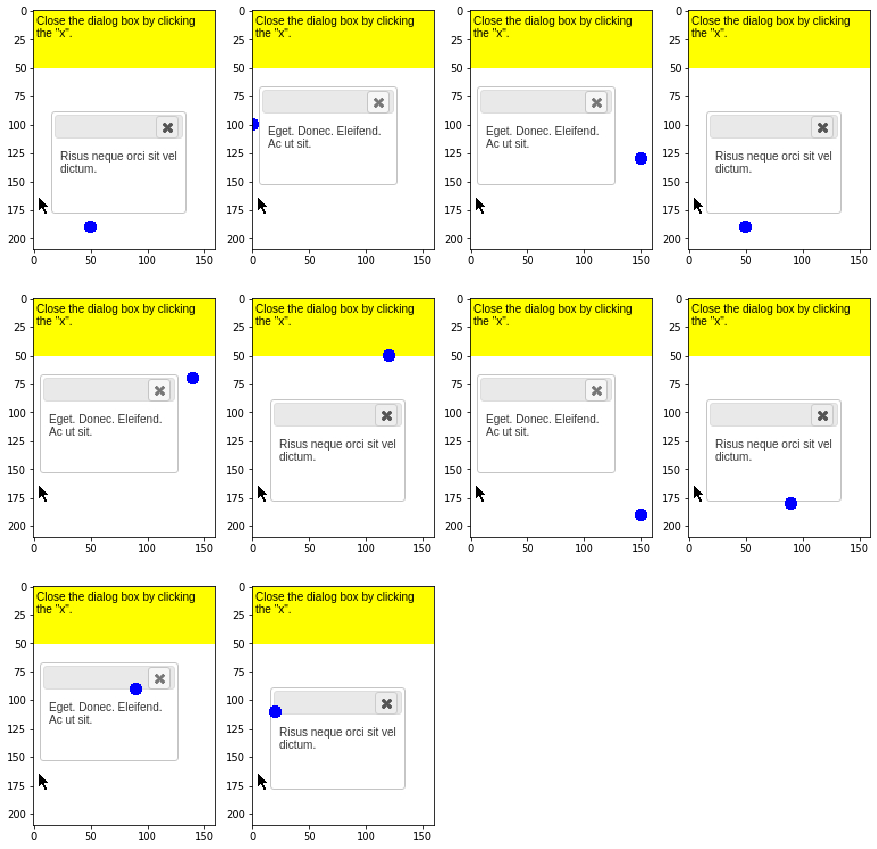

In [156]:
fig = plt.figure(figsize=(15, 15))

rows = 3
for i, img in enumerate(imgs, start=1):
    fig.add_subplot(rows, np.ceil(len(imgs)/rows), i)
    plt.imshow(img)
plt.show()

Hm, that doesn't look OK. We've clicked on the wrong places and still got positive reward.

Idea: after checking `SoftmaxClickMouse` [source code](https://github.com/openai/universe/blob/master/universe/wrappers/experimental/action_space.py#L65), looks like it need to be applied before cropping. Let's check.

In [316]:
env = gym.make("wob.mini.ClickDialog-v0")
env = SoftmaxClickMouse(env)
env = MiniWoBCropper(env)
env = TrajectoryTracking(env, size=10)
url = remotes_url(count=1)

env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=1, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

[2019-06-30 23:28:57,160] Making new env: wob.mini.ClickDialog-v0
[2019-06-30 23:28:57,163] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-06-30 23:28:57,164] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-06-30 23:28:57,167] Using the golang VNC implementation
[2019-06-30 23:28:57,168] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-06-30 23:28:57,195] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai


In [317]:
while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-06-30 23:29:13,626] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-06-30 23:29:13,708] [0:localhost:5900] Initial reset complete: episode_id=17978


In [318]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=1.0, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)

In [319]:
# populate buffer to get some trajectories
for _ in range(100):
    buffer.populate(1)
    for rw, st in exp_source.pop_rewards_steps():
        print("Episode done with %d steps and %.3f reward" % (st, rw))

[2019-06-30 23:29:15,527] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


Episode done with 12 steps and -1.000 reward
Episode done with 5 steps and 0.590 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and 0.000 reward
Episode done with 11 steps and -2.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 8 steps and 0.304 reward
Episode done with 1 steps and 0.952 reward


In [321]:
list(map(len, env.trajectories))

[5, 10, 11, 10, 11, 10, 11, 10, 8, 1]

In [322]:
# you might want to select different trajectory to check, I've chosen not very long one with positive reward
tr = env.trajectories[0]
tr_obs, tr_act, tr_rw = zip(*tr)

In [323]:
tr_act

(176, 80, 101, 163, 43)

In [324]:
tr_rw

(0.0, 0.0, 0.0, 0.0, 0.59)

In [325]:
imgs = [get_obs_img(obs, action=act) for obs, act in zip(tr_obs, tr_act)]

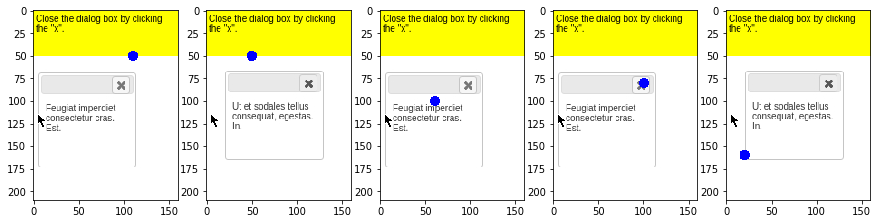

In [326]:
fig = plt.figure(figsize=(15, 15))

rows = 1
for i, img in enumerate(imgs, start=1):
    fig.add_subplot(rows, np.ceil(len(imgs)/rows), i)
    plt.imshow(img)
plt.show()

Aha, looks better. But let's notice that the final step is wrong. Due to VNC delay, we've got reward not immediately, but on our next action. That might introduce confusion to the method. In theory, DQN should be able to deal with that, but theory == practice only for theoreticians. This last step definitely harms the convergence.

Let's fix it.

## Fix the last step

If we think a little about this problem, this issue of the last step is more fundamental and caused by consistent 1-step shift between actions and observations.

Classical Gym API, Universe supposed to emulate works simple: we call `step(action)` method and get the outcome **of this action** -- rewards, observations and is_done flag. But in Universe, the observation we get from `step` is VNC screen **right now**. Our actions will be applied only after some delay.

So, the simplest solution, would be to artificially introduce the extra one-step gap in action-observation stream. Unfortunatelly we cannot pick into the future observations to return them, so, we need to inject into samples gathering process in the `ptan` library. 

Communications between the environment, agent and replay buffer is implemented in [`ExperienceSource` class](https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L18) and in its subclass [`ExperienceSourceFirstLast` class](https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L158).

Implementation of `ExperienceSource` is not very pleasant thing to study (mostly due to vectorized environments support), but the basic idea is simple: we have set of environments (or one vectorized environment) and obtain from them N-step trajectory subchunks. Class `ExperienceSource` provides us full N observations of the subchank, `ExperienceSourceFirstLast` returns only the first and the last observations, calculating accumulated reward in between.

To shift the actions in the chunk one step ahead, we need to modify `ExperienceSourceFirstLast` implementation.

Below are demonstrations of `ExperienceSource` and `ExperienceSourceFirstLast`

In [255]:
class EnvTest(gym.Env):
    def __init__(self):
        self.v = 0
        
    def reset(self):
        self.v = 0
        return self.v
    
    def step(self, action):
        self.v += 1
        is_done = self.v > 5
        return self.v, 1.0, is_done, {}
    
class AgentTest(ptan.agent.BaseAgent):
    def __call__(self, states, agent_states):
        new_states = [1 + s if s is not None else 0 for s in agent_states]
        return new_states, new_states

In [256]:
env = EnvTest()
agent = AgentTest()

In [257]:
exp_src = ptan.experience.ExperienceSource(env, agent, steps_count=2)

for idx, e in enumerate(exp_src):
    print(e)
    if idx > 6:
        break

(Experience(state=0, action=0, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))
(Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=2, reward=1.0, done=False))
(Experience(state=2, action=2, reward=1.0, done=False), Experience(state=3, action=3, reward=1.0, done=False))
(Experience(state=3, action=3, reward=1.0, done=False), Experience(state=4, action=4, reward=1.0, done=False))
(Experience(state=4, action=4, reward=1.0, done=False), Experience(state=5, action=5, reward=1.0, done=True))
(Experience(state=4, action=4, reward=1.0, done=False), Experience(state=5, action=5, reward=1.0, done=True))
(Experience(state=5, action=5, reward=1.0, done=True),)
(Experience(state=0, action=0, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))


Double entry of `(Experience(state=4, action=4, reward=4, done=False), Experience(state=5, action=5, reward=5, done=True))` is a bug fixed in `master` branch of `ptan` 

`¯\_(ツ)_/¯`

In [258]:
exp_src = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=1.0)

for idx, e in enumerate(exp_src):
    print(e)
    if idx > 6:
        break

ExperienceFirstLast(state=0, action=0, reward=1.0, last_state=1)
ExperienceFirstLast(state=1, action=1, reward=1.0, last_state=2)
ExperienceFirstLast(state=2, action=2, reward=1.0, last_state=3)
ExperienceFirstLast(state=3, action=3, reward=1.0, last_state=4)
ExperienceFirstLast(state=4, action=4, reward=1.0, last_state=5)
ExperienceFirstLast(state=4, action=4, reward=1.0, last_state=5)
ExperienceFirstLast(state=5, action=5, reward=1.0, last_state=None)
ExperienceFirstLast(state=0, action=0, reward=1.0, last_state=1)


The same, but with longer subchunks of trajectories

In [259]:
exp_src = ptan.experience.ExperienceSource(env, agent, steps_count=3)

for idx, e in enumerate(exp_src):
    print(e)
    if idx > 6:
        break

(Experience(state=0, action=0, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=2, reward=1.0, done=False))
(Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=2, reward=1.0, done=False), Experience(state=3, action=3, reward=1.0, done=False))
(Experience(state=2, action=2, reward=1.0, done=False), Experience(state=3, action=3, reward=1.0, done=False), Experience(state=4, action=4, reward=1.0, done=False))
(Experience(state=3, action=3, reward=1.0, done=False), Experience(state=4, action=4, reward=1.0, done=False), Experience(state=5, action=5, reward=1.0, done=True))
(Experience(state=3, action=3, reward=1.0, done=False), Experience(state=4, action=4, reward=1.0, done=False), Experience(state=5, action=5, reward=1.0, done=True))
(Experience(state=4, action=4, reward=1.0, done=False), Experience(state=5, action=5, reward=1.0, done=True))
(Experience(state=5, action=5, reward=1.0, done=True),)
(Exper

In [260]:
exp_src = ptan.experience.ExperienceSourceFirstLast(env, agent, steps_count=2, gamma=1.0)

for idx, e in enumerate(exp_src):
    print(e)
    if idx > 6:
        break

ExperienceFirstLast(state=0, action=0, reward=2.0, last_state=2)
ExperienceFirstLast(state=1, action=1, reward=2.0, last_state=3)
ExperienceFirstLast(state=2, action=2, reward=2.0, last_state=4)
ExperienceFirstLast(state=3, action=3, reward=2.0, last_state=5)
ExperienceFirstLast(state=3, action=3, reward=2.0, last_state=5)
ExperienceFirstLast(state=4, action=4, reward=2.0, last_state=None)
ExperienceFirstLast(state=5, action=5, reward=1.0, last_state=None)
ExperienceFirstLast(state=0, action=0, reward=2.0, last_state=2)


In [380]:
class ExperienceSourceShiftActions(ptan.experience.ExperienceSource):
    """
    Modified version of ExperienceSourceFirstLast class 
    https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L158
    
    Implementation is not generic, should be improved and contributed to ptan lib
    """
    def __init__(self, env, agent, gamma, shift_steps=1, vectorized=False):
        assert isinstance(gamma, float)
        super(ExperienceSourceShiftActions, self).__init__(env, agent, shift_steps+2, 1, vectorized=vectorized)
        self.gamma = gamma
        self.shift_steps = shift_steps

    def __iter__(self):
        for exp in super(ExperienceSourceShiftActions, self).__iter__():
            if len(exp) <= self.shift_steps:
                continue
            if exp[-1].done and len(exp) < self.shift_steps+2:
                last_state = None
                elems = exp
            else:
                last_state = exp[-1].state
                elems = exp[:-1]
            total_reward = 0.0
            for e in reversed(elems):
                total_reward *= self.gamma
                total_reward += e.reward
            yield ptan.experience.ExperienceFirstLast(state=exp[self.shift_steps].state, action=exp[0].action,
                                      reward=total_reward, last_state=last_state)


In [270]:
exp_src = ExperienceSourceShiftActions(env, agent, gamma=1.0)

for idx, e in enumerate(exp_src):
    print(e)
    if idx > 6:
        break

ExperienceFirstLast(state=1, action=0, reward=2.0, last_state=2)
ExperienceFirstLast(state=2, action=1, reward=2.0, last_state=3)
ExperienceFirstLast(state=3, action=2, reward=2.0, last_state=4)
ExperienceFirstLast(state=4, action=3, reward=2.0, last_state=5)
ExperienceFirstLast(state=4, action=3, reward=2.0, last_state=5)
ExperienceFirstLast(state=5, action=4, reward=2.0, last_state=None)
ExperienceFirstLast(state=1, action=0, reward=2.0, last_state=2)
ExperienceFirstLast(state=2, action=1, reward=2.0, last_state=3)


## Check new trajectories

In [397]:
env = gym.make("wob.mini.ClickDialog-v0")
env = SoftmaxClickMouse(env)
env = MiniWoBCropper(env)
env = TrajectoryTracking(env, size=10)
url = remotes_url(count=1)

env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=1, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

[2019-07-01 00:03:52,893] Making new env: wob.mini.ClickDialog-v0
/home/shmuma/anaconda3/envs/miniwob/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-07-01 00:03:52,895] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-01 00:03:52,896] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-01 00:03:52,898] Using the golang VNC implementation
[2019-07-01 00:03:52,899] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-01 00:03:52,914] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC cl

In [398]:
while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-07-01 00:04:09,369] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-07-01 00:04:09,389] [0:localhost:5900] Initial reset complete: episode_id=100


In [399]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
#exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=1.0, vectorized=True)
exp_source = ExperienceSourceShiftActions(env, agent, gamma=1.0, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)

In [400]:
# populate buffer to get some trajectories
for _ in range(100):
    buffer.populate(1)
    for rw, st in exp_source.pop_rewards_steps():
        print("Episode done with %d steps and %.3f reward" % (st, rw))

[2019-07-01 00:04:11,023] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


Episode done with 6 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 8 steps and 0.292 reward
Episode done with 5 steps and 0.551 reward


In [401]:
list(map(len, env.trajectories))

[11, 10, 11, 10, 11, 10, 11, 8, 5, 10]

In [405]:
# you might want to select different trajectory to check, I've chosen not very long one with positive reward
tr = env.trajectories[-2]
tr_obs, tr_act, tr_rw = zip(*tr)

In [406]:
tr_act

(177, 193, 183, 165, 209)

In [407]:
tr_rw

(0.0, 0.0, 0.0, 0.0, 0.5508000000000001)

In [408]:
imgs = [get_obs_img(obs, action=act) for obs, act in zip(tr_obs, tr_act)]

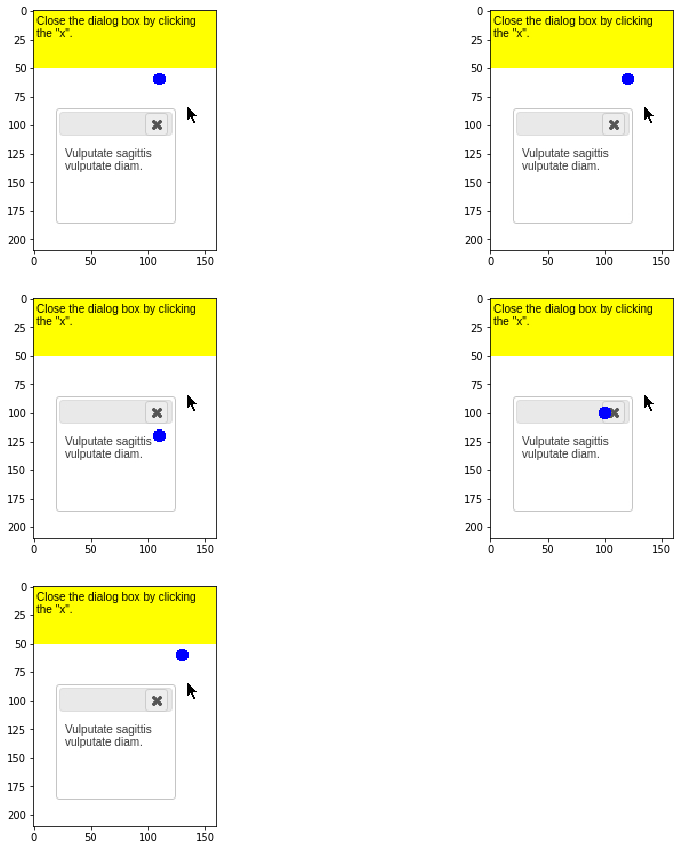

In [409]:
fig = plt.figure(figsize=(15, 15))

rows = 3
for i, img in enumerate(imgs, start=1):
    fig.add_subplot(rows, np.ceil(len(imgs)/rows), i)
    plt.imshow(img)
plt.show()

In [410]:
imgs = []
for e in buffer:
    if e.reward > 0:
        imgs.append(get_obs_img(e.state, action=e.action))

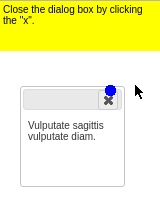

In [415]:
imgs[0]

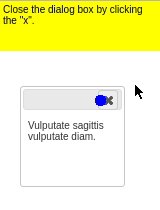

In [416]:
imgs[1]

Ok, looks better

## Trying our fixes

In [445]:
GAMMA = 0.9
REPLAY_SIZE = 10000
MIN_REPLAY = 100
TGT_SYNC = 100
BATCH_SIZE = 16
LR = 1e-3
DEVICE = "cuda"  
#DEVICE = "cpu"

INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.2
STEPS_EPSILON = 1000

In [446]:
env = gym.make("wob.mini.ClickDialog-v0")
# note the order change!
env = SoftmaxClickMouse(env)
env = MiniWoBCropper(env)
url = remotes_url(count=1)

env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=1, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

[2019-07-01 10:48:16,052] Making new env: wob.mini.ClickDialog-v0
/home/shmuma/anaconda3/envs/miniwob/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-07-01 10:48:16,054] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-01 10:48:16,054] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-01 10:48:16,055] Using the golang VNC implementation
[2019-07-01 10:48:16,058] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-01 10:48:16,091] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC cl

In [447]:
while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-07-01 10:48:32,551] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-07-01 10:48:32,600] [0:localhost:5900] Initial reset complete: episode_id=147


In [448]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
tgt_net = ptan.agent.TargetNet(net)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=INITIAL_EPSILON, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
#exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, vectorized=True)
exp_source = ExperienceSourceShiftActions(env, agent, gamma=GAMMA, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)
optimizer = optim.Adam(net.parameters(), LR)

In [ ]:
episode_rewards = []
episode_steps = []
losses = []
steps = 0
last_ts = time.time()
last_steps = 0

while True:
    steps += 1
    buffer.populate(1)
    r = exp_source.pop_rewards_steps()
    if r:
        for rw, st in r:
            episode_rewards.append(rw)
            episode_steps.append(st)
        speed = (steps - last_steps) / (time.time() - last_ts)
        print("%d: Done %d episodes, last 100 means: reward=%.3f, steps=%.3f, speed=%.2f steps/s, eps=%.2f" % (
            steps, len(episode_rewards), np.mean(episode_rewards[-100:]), 
            np.mean(episode_steps[-100:]), speed, action_selector.epsilon
        ))
        last_ts = time.time()
        last_steps = steps
        if np.mean(episode_rewards[-100:]) > 0.9:
            print("You solved the env! Congrats!")
            break
    if len(buffer) < MIN_REPLAY:
        continue
    batch = buffer.sample(BATCH_SIZE)
    state_v, actions_v, ref_q_v = unpack_batch(batch, tgt_net.target_model, gamma=GAMMA, device=DEVICE)
    optimizer.zero_grad()
    q_v = net(state_v)
    q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    loss_v = F.mse_loss(q_v, ref_q_v)
    loss_v.backward()
    optimizer.step()
    losses.append(loss_v.item())
    
    if steps % TGT_SYNC == 0:
        print("%d: nets synced, mean loss for last 100 steps = %.3f" % (
            steps, np.mean(losses[-100:])))
        tgt_net.sync()
    action_selector.epsilon = max(FINAL_EPSILON, INITIAL_EPSILON - steps / STEPS_EPSILON)

[2019-07-01 10:48:34,209] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


10: Done 1 episodes, last 100 means: reward=-1.000, steps=10.000, speed=0.71 steps/s, eps=1.00
19: Done 2 episodes, last 100 means: reward=-1.000, steps=10.000, speed=0.90 steps/s, eps=1.00
29: Done 3 episodes, last 100 means: reward=-1.000, steps=10.333, speed=0.91 steps/s, eps=1.00
38: Done 4 episodes, last 100 means: reward=-1.000, steps=10.250, speed=0.90 steps/s, eps=1.00
43: Done 5 episodes, last 100 means: reward=-0.700, steps=9.400, speed=0.83 steps/s, eps=1.00
52: Done 6 episodes, last 100 means: reward=-0.750, steps=9.500, speed=0.90 steps/s, eps=1.00
62: Done 7 episodes, last 100 means: reward=-0.785, steps=9.714, speed=0.91 steps/s, eps=1.00
71: Done 8 episodes, last 100 means: reward=-0.812, steps=9.750, speed=0.90 steps/s, eps=1.00
81: Done 9 episodes, last 100 means: reward=-0.833, steps=9.889, speed=0.91 steps/s, eps=1.00
90: Done 10 episodes, last 100 means: reward=-0.850, steps=9.900, speed=0.90 steps/s, eps=1.00
100: Done 11 episodes, last 100 means: reward=-0.863, s

[2019-07-01 10:59:48,410] Throttle fell behind by 1.04s; lost 1.04 frames


560: Done 67 episodes, last 100 means: reward=-0.850, steps=9.373, speed=0.81 steps/s, eps=0.44
568: Done 68 episodes, last 100 means: reward=-0.852, steps=9.368, speed=0.81 steps/s, eps=0.43
577: Done 69 episodes, last 100 means: reward=-0.854, steps=9.377, speed=0.83 steps/s, eps=0.42
586: Done 70 episodes, last 100 means: reward=-0.856, steps=9.386, speed=0.83 steps/s, eps=0.42
594: Done 71 episodes, last 100 means: reward=-0.858, steps=9.380, speed=0.81 steps/s, eps=0.41
600: nets synced, mean loss for last 100 steps = 0.125


[2019-07-01 11:00:40,746] Throttle fell behind by 1.04s; lost 1.04 frames


603: Done 72 episodes, last 100 means: reward=-0.860, steps=9.389, speed=0.81 steps/s, eps=0.40
611: Done 73 episodes, last 100 means: reward=-0.862, steps=9.384, speed=0.82 steps/s, eps=0.39
620: Done 74 episodes, last 100 means: reward=-0.864, steps=9.392, speed=0.83 steps/s, eps=0.38
629: Done 75 episodes, last 100 means: reward=-0.866, steps=9.400, speed=0.83 steps/s, eps=0.37
637: Done 76 episodes, last 100 means: reward=-0.867, steps=9.395, speed=0.82 steps/s, eps=0.36
646: Done 77 episodes, last 100 means: reward=-0.869, steps=9.403, speed=0.92 steps/s, eps=0.35
647: Done 78 episodes, last 100 means: reward=-0.858, steps=9.321, speed=0.25 steps/s, eps=0.35
655: Done 79 episodes, last 100 means: reward=-0.850, steps=9.316, speed=0.82 steps/s, eps=0.35
664: Done 80 episodes, last 100 means: reward=-0.852, steps=9.325, speed=0.83 steps/s, eps=0.34
673: Done 81 episodes, last 100 means: reward=-0.853, steps=9.333, speed=0.83 steps/s, eps=0.33
682: Done 82 episodes, last 100 means: r

[2019-07-01 11:10:31,115] Throttle fell behind by 1.06s; lost 1.06 frames


1087: Done 131 episodes, last 100 means: reward=-0.899, steps=9.320, speed=0.71 steps/s, eps=0.20
1095: Done 132 episodes, last 100 means: reward=-0.899, steps=9.310, speed=0.82 steps/s, eps=0.20
1100: nets synced, mean loss for last 100 steps = 0.209
1104: Done 133 episodes, last 100 means: reward=-0.899, steps=9.310, speed=0.83 steps/s, eps=0.20
1112: Done 134 episodes, last 100 means: reward=-0.899, steps=9.310, speed=0.82 steps/s, eps=0.20


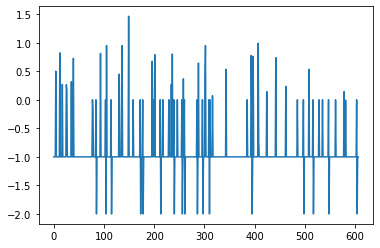

In [453]:
plt.plot(episode_rewards)

Ok, not very helpful. Need to try other approaches.

## Overfit to subset of samples

Normal approach to debug ML/DL methods is to try to overfit to some known set of samples. This allows us to inspect those samples and check values predicted by the model.

Overall plan is the following:
* reuse our class `TrajectoryTracking` to have access to trajectories,
* play 10-20 episodes gathering data
* take several final steps of successfull episodes (with positive reward) and several final steps from failed episodes
* train on this data for several epoches
* check training dynamics and values returned by the model
* think

If you feel yourself brave enough, you can try to implement this yourself without peeking into the next section.

In [498]:
env = gym.make("wob.mini.ClickDialog-v0")
env = SoftmaxClickMouse(env)
env = MiniWoBCropper(env)
env = TrajectoryTracking(env, size=10)
url = remotes_url(count=1)

env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=1, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-07-01 13:58:57,493] Making new env: wob.mini.ClickDialog-v0
/home/shmuma/anaconda3/envs/miniwob/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2019-07-01 13:58:57,495] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-01 13:58:57,496] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-01 13:58:57,501] Using the golang VNC implementation
[2019-07-01 13:58:57,502] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-01 13:58:57,517] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC cl

In [499]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
#exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=1.0, vectorized=True)
exp_source = ExperienceSourceShiftActions(env, agent, gamma=1.0, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)

In [ ]:
# wait for given amount of trajectories of both kind
COUNT_REQUIRED = 2
positive_traj = []
negative_traj = []

while len(positive_traj) < COUNT_REQUIRED or len(negative_traj) < COUNT_REQUIRED:
    buffer.populate(1)
    for rw, st in exp_source.pop_rewards_steps():
        print("Episode done with %d steps and %.3f reward" % (st, rw))
        if rw > 0.2:
            positive_traj.append(env.trajectories[-1])
        elif rw < -0.2 and len(negative_traj) <= COUNT_REQUIRED:
            negative_traj.append(env.trajectories[-1])

[2019-07-01 13:59:15,634] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


Episode done with 5 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and 0.000 reward
Episode done with 11 steps and -2.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 10 steps and -1.000 reward
Episode done with 11 steps and -1.000 reward
Episode done with 6 steps and 0.496 reward
Episode done with 10 steps and -1.000 reward
Episode done w

It might take some time before you get two episodes with positive reward.

Btw, sparcity of good examples might be the reason of bad convergence. One of the way of dealing with that could be increase of `fps` option on Env creation, just to have more clicks done.

In [504]:
for s in positive_traj[0]:
    print(s[1], s[2])

241 0.0
40 0.0
241 0.0
170 0.0
180 0.0
149 0.496


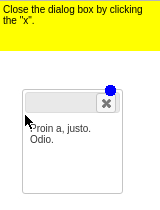

In [505]:
img = get_obs_img(positive_traj[0][-1][0], action=positive_traj[0][-2][1])
img

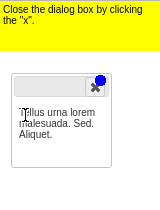

In [507]:
img = get_obs_img(positive_traj[1][-1][0], action=positive_traj[1][-2][1])
img

In [514]:
training_positive = []

# find this sample in our replay buffer
for traj in positive_traj:
    for sample in buffer:
        if (sample.state == traj[-1][0]).all() and sample.action == traj[-2][1] and sample.last_state is None:
            training_positive.append(sample)

In [516]:
training_negative = []

for traj in negative_traj:
    for sample in buffer:
        if (sample.state == traj[-1][0]).all() and sample.action == traj[-2][1] and sample.last_state is None:
            training_negative.append(sample)

In [522]:
training_negative = []

for sample in buffer:
    if sample.last_state is None and sample.reward < -0.2:
        training_negative.append(sample)
    if len(training_negative) == 2:
        break

In [524]:
batch = list(training_positive)
batch.extend(training_negative)

In [537]:
optimizer = optim.Adam(net.parameters(), LR)

In [538]:
# training the net
losses = []
q_vals = []

for _ in range(100):
    state_v, actions_v, ref_q_v = unpack_batch(batch, net, gamma=GAMMA, device=DEVICE)
    optimizer.zero_grad()
    q_v = net(state_v)
    q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    loss_v = F.mse_loss(q_v, ref_q_v)
    loss_v.backward()
    optimizer.step()
    losses.append(loss_v.item())
    q_vals.append(q_v.cpu().detach().numpy())

In [539]:
losses[:10]

[0.6471409201622009,
 0.6269791126251221,
 0.6078374981880188,
 0.5866777896881104,
 0.563583254814148,
 0.5370932221412659,
 0.5059386491775513,
 0.47159644961357117,
 0.4330199062824249,
 0.38929373025894165]

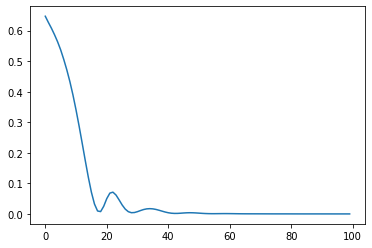

In [542]:
plt.plot(losses);

In [543]:
ref_q_v

tensor([ 0.4960,  0.5094, -1.0000, -1.0000], device='cuda:0')

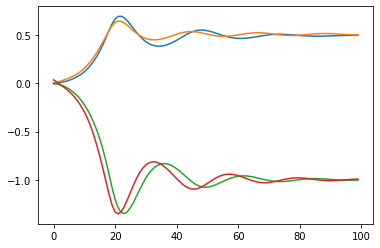

In [548]:
a, b, c, d = zip(*q_vals)
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot(d);

Also looks ok.

Let's check our idea about low FPS in environment

## Increase FPS

In [549]:
GAMMA = 0.9
REPLAY_SIZE = 10000
MIN_REPLAY = 100
TGT_SYNC = 100
BATCH_SIZE = 16
LR = 1e-3
DEVICE = "cuda"  
#DEVICE = "cpu"

INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.2
STEPS_EPSILON = 1000

In [551]:
env = gym.make("wob.mini.ClickDialog-v0")

env = SoftmaxClickMouse(env)
env = MiniWoBCropper(env)
url = remotes_url(count=1)

# Note FPS=10
env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=10, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-07-01 15:43:08,252] Making new env: wob.mini.ClickDialog-v0
[2019-07-01 15:43:08,254] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-01 15:43:08,255] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-01 15:43:08,257] Using the golang VNC implementation
[2019-07-01 15:43:08,257] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-01 15:43:08,280] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2019-07-01 15:43:24,742] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-07-01 15:43:24,787] [0:localhost:5900] Initial reset complete:

In [552]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
tgt_net = ptan.agent.TargetNet(net)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=INITIAL_EPSILON, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
#exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, vectorized=True)
exp_source = ExperienceSourceShiftActions(env, agent, gamma=GAMMA, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)
optimizer = optim.Adam(net.parameters(), LR)

In [553]:
episode_rewards = []
episode_steps = []
losses = []
steps = 0
last_ts = time.time()
last_steps = 0

while True:
    steps += 1
    buffer.populate(1)
    r = exp_source.pop_rewards_steps()
    if r:
        for rw, st in r:
            episode_rewards.append(rw)
            episode_steps.append(st)
        speed = (steps - last_steps) / (time.time() - last_ts)
        print("%d: Done %d episodes, last 100 means: reward=%.3f, steps=%.3f, speed=%.2f steps/s, eps=%.2f" % (
            steps, len(episode_rewards), np.mean(episode_rewards[-100:]), 
            np.mean(episode_steps[-100:]), speed, action_selector.epsilon
        ))
        last_ts = time.time()
        last_steps = steps
        if np.mean(episode_rewards[-100:]) > 0.9:
            print("You solved the env! Congrats!")
            break
    if len(buffer) < MIN_REPLAY:
        continue
    batch = buffer.sample(BATCH_SIZE)
    state_v, actions_v, ref_q_v = unpack_batch(batch, tgt_net.target_model, gamma=GAMMA, device=DEVICE)
    optimizer.zero_grad()
    q_v = net(state_v)
    q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    loss_v = F.mse_loss(q_v, ref_q_v)
    loss_v.backward()
    optimizer.step()
    losses.append(loss_v.item())
    
    if steps % TGT_SYNC == 0:
        print("%d: nets synced, mean loss for last 100 steps = %.3f" % (
            steps, np.mean(losses[-100:])))
        tgt_net.sync()
    action_selector.epsilon = max(FINAL_EPSILON, INITIAL_EPSILON - steps / STEPS_EPSILON)

[2019-07-01 15:43:51,101] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


22: Done 1 episodes, last 100 means: reward=0.061, steps=22.000, speed=8.44 steps/s, eps=1.00
51: Done 2 episodes, last 100 means: reward=0.406, steps=26.000, speed=9.65 steps/s, eps=1.00
68: Done 3 episodes, last 100 means: reward=0.560, steps=23.333, speed=9.31 steps/s, eps=1.00
82: Done 4 episodes, last 100 means: reward=0.420, steps=21.250, speed=9.27 steps/s, eps=1.00
100: nets synced, mean loss for last 100 steps = 0.010
148: Done 5 episodes, last 100 means: reward=0.519, steps=30.400, speed=6.12 steps/s, eps=0.85
182: Done 6 episodes, last 100 means: reward=0.491, steps=31.167, speed=4.81 steps/s, eps=0.82
200: nets synced, mean loss for last 100 steps = 0.022
239: Done 7 episodes, last 100 means: reward=0.278, steps=35.000, speed=5.42 steps/s, eps=0.76
289: Done 8 episodes, last 100 means: reward=0.118, steps=37.000, speed=4.84 steps/s, eps=0.71
300: nets synced, mean loss for last 100 steps = 0.032
345: Done 9 episodes, last 100 means: reward=-0.006, steps=39.222, speed=5.33 s

[2019-07-01 15:47:48,504] [0:localhost:5900] Could not recalibrate network: [Failure instance: Traceback (failure with no frames): <class 'universe.error.Error'>: Can't send message to closed connection
]


1300: nets synced, mean loss for last 100 steps = 0.732
1312: Done 30 episodes, last 100 means: reward=-0.324, steps=44.700, speed=5.19 steps/s, eps=0.20
1363: Done 31 episodes, last 100 means: reward=-0.346, steps=44.935, speed=4.93 steps/s, eps=0.20
1400: nets synced, mean loss for last 100 steps = 1.073
1416: Done 32 episodes, last 100 means: reward=-0.367, steps=45.219, speed=5.08 steps/s, eps=0.20
1473: Done 33 episodes, last 100 means: reward=-0.386, steps=45.606, speed=5.37 steps/s, eps=0.20
1500: nets synced, mean loss for last 100 steps = 1.431
1533: Done 34 episodes, last 100 means: reward=-0.404, steps=46.059, speed=5.74 steps/s, eps=0.20
1566: Done 35 episodes, last 100 means: reward=-0.392, steps=45.714, speed=5.22 steps/s, eps=0.20
1600: nets synced, mean loss for last 100 steps = 1.718
1621: Done 36 episodes, last 100 means: reward=-0.409, steps=46.000, speed=5.22 steps/s, eps=0.20
1673: Done 37 episodes, last 100 means: reward=-0.425, steps=46.189, speed=5.03 steps/s, e

4373: Done 97 episodes, last 100 means: reward=-0.511, steps=46.113, speed=5.12 steps/s, eps=0.20
4400: nets synced, mean loss for last 100 steps = 295.573
4429: Done 98 episodes, last 100 means: reward=-0.516, steps=46.224, speed=5.34 steps/s, eps=0.20
4481: Done 99 episodes, last 100 means: reward=-0.521, steps=46.293, speed=4.83 steps/s, eps=0.20
4500: nets synced, mean loss for last 100 steps = 414.782
4534: Done 100 episodes, last 100 means: reward=-0.526, steps=46.370, speed=5.14 steps/s, eps=0.20
4589: Done 101 episodes, last 100 means: reward=-0.537, steps=46.710, speed=5.18 steps/s, eps=0.20


KeyboardInterrupt: 

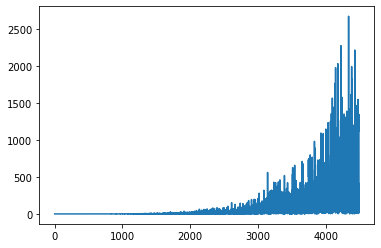

In [554]:
plt.plot(losses);

Loss is going overboard, might be caused by several reasons:
* we do net sync too frequently
* learning rate is too high

## Experimenting with params

In [616]:
GAMMA = 0.9
REPLAY_SIZE = 10000
MIN_REPLAY = 1000
TGT_SYNC = 200
BATCH_SIZE = 16
LR = 1e-4
DEVICE = "cuda"  
#DEVICE = "cpu"

INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.2
STEPS_EPSILON = 2000

In [617]:
env = gym.make("wob.mini.ClickDialog-v0")

env = SoftmaxClickMouse(env)
env = MiniWoBCropper(env)
url = remotes_url(count=1)

# Note FPS=10
env.configure(remotes=url, docker_image=DOCKER_IMAGE, fps=10, vnc_kwargs={
        'encoding': 'tight', 'compress_level': 0,
        'fine_quality_level': 100, 'subsample_level': 0
    })
obs = env.reset()

while obs[0] is None:
    a = env.action_space.sample()
    obs, reward, is_done, info = env.step([a])
    time.sleep(1)

[2019-07-01 17:24:08,802] Making new env: wob.mini.ClickDialog-v0
[2019-07-01 17:24:08,804] Using SoftmaxClickMouse with action_region=(10, 125, 170, 285), noclick_regions=[]
[2019-07-01 17:24:08,805] SoftmaxClickMouse noclick regions removed 0 of 256 actions
[2019-07-01 17:24:08,810] Using the golang VNC implementation
[2019-07-01 17:24:08,811] Using VNCSession arguments: {'encoding': 'tight', 'compress_level': 0, 'fine_quality_level': 100, 'subsample_level': 0, 'start_timeout': 7}. (Customize by running "env.configure(vnc_kwargs={...})"
[2019-07-01 17:24:08,833] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2019-07-01 17:24:25,257] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0
[2019-07-01 17:24:25,310] [0:localhost:5900] Initial reset complete:

In [618]:
net = Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
tgt_net = ptan.agent.TargetNet(net)

parent_selector = ptan.actions.ArgmaxActionSelector()
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=INITIAL_EPSILON, selector=parent_selector) 
agent = ptan.agent.DQNAgent(net, action_selector, device=DEVICE)
#exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, vectorized=True)
exp_source = ExperienceSourceShiftActions(env, agent, gamma=GAMMA, vectorized=True)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)
optimizer = optim.Adam(net.parameters(), LR)

In [619]:
episode_rewards = []
episode_steps = []
losses = []
steps = 0
last_ts = time.time()
last_steps = 0

while True:
    steps += 1
    buffer.populate(1)
    r = exp_source.pop_rewards_steps()
    if r:
        for rw, st in r:
            episode_rewards.append(rw)
            episode_steps.append(st)
        speed = (steps - last_steps) / (time.time() - last_ts)
        print("%d: Done %d episodes, last 10 means: reward=%.3f, steps=%.3f, speed=%.2f steps/s, eps=%.2f" % (
            steps, len(episode_rewards), np.mean(episode_rewards[-10:]), 
            np.mean(episode_steps[-10:]), speed, action_selector.epsilon
        ))
        last_ts = time.time()
        last_steps = steps
        if np.mean(episode_rewards[-10:]) > 0.9:
            print("You solved the env! Congrats!")
            break
    if len(buffer) < MIN_REPLAY:
        continue
    batch = buffer.sample(BATCH_SIZE)
    state_v, actions_v, ref_q_v = unpack_batch(batch, tgt_net.target_model, gamma=GAMMA, device=DEVICE)
    optimizer.zero_grad()
    q_v = net(state_v)
    q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    loss_v = F.mse_loss(q_v, ref_q_v)
    loss_v.backward()
    optimizer.step()
    losses.append(loss_v.item())
    
    if steps % TGT_SYNC == 0:
        print("%d: nets synced, mean loss for last 10 steps = %.3f" % (
            steps, np.mean(losses[-10:])))
        tgt_net.sync()
    action_selector.epsilon = max(FINAL_EPSILON, INITIAL_EPSILON - (steps - MIN_REPLAY) / STEPS_EPSILON)

[2019-07-01 17:24:27,066] [0:localhost:5900] Sending reset for env_id=wob.mini.ClickDialog-v0 fps=60 episode_id=0


95: Done 1 episodes, last 10 means: reward=-1.000, steps=95.000, speed=9.53 steps/s, eps=1.00
109: Done 2 episodes, last 10 means: reward=-0.051, steps=55.000, speed=8.98 steps/s, eps=1.00
212: Done 3 episodes, last 10 means: reward=-0.367, steps=71.333, speed=9.84 steps/s, eps=1.00
235: Done 4 episodes, last 10 means: reward=-0.072, steps=59.500, speed=9.54 steps/s, eps=1.00
321: Done 5 episodes, last 10 means: reward=-0.022, steps=65.000, speed=9.82 steps/s, eps=1.00
332: Done 6 episodes, last 10 means: reward=0.136, steps=56.167, speed=9.15 steps/s, eps=1.00
435: Done 7 episodes, last 10 means: reward=-0.026, steps=63.000, speed=9.79 steps/s, eps=1.00
501: Done 8 episodes, last 10 means: reward=0.024, steps=63.500, speed=9.81 steps/s, eps=1.00
548: Done 9 episodes, last 10 means: reward=0.084, steps=61.778, speed=9.68 steps/s, eps=1.00
651: Done 10 episodes, last 10 means: reward=-0.024, steps=66.000, speed=9.83 steps/s, eps=1.00
660: Done 11 episodes, last 10 means: reward=0.171, s

3546: Done 79 episodes, last 10 means: reward=-0.793, steps=54.100, speed=4.82 steps/s, eps=0.20
3596: Done 80 episodes, last 10 means: reward=-0.893, steps=53.400, speed=4.78 steps/s, eps=0.20
3600: nets synced, mean loss for last 10 steps = 0.161
3653: Done 81 episodes, last 10 means: reward=-0.893, steps=53.700, speed=5.37 steps/s, eps=0.20
3703: Done 82 episodes, last 10 means: reward=-1.000, steps=53.800, speed=4.73 steps/s, eps=0.20
3757: Done 83 episodes, last 10 means: reward=-1.000, steps=54.000, speed=5.16 steps/s, eps=0.20
3800: nets synced, mean loss for last 10 steps = 0.223
3814: Done 84 episodes, last 10 means: reward=-1.000, steps=54.600, speed=5.47 steps/s, eps=0.20
3872: Done 85 episodes, last 10 means: reward=-1.000, steps=55.000, speed=5.53 steps/s, eps=0.20
3921: Done 86 episodes, last 10 means: reward=-1.000, steps=54.400, speed=4.56 steps/s, eps=0.20
3971: Done 87 episodes, last 10 means: reward=-1.000, steps=53.900, speed=4.87 steps/s, eps=0.20
4000: nets synced

KeyboardInterrupt: 

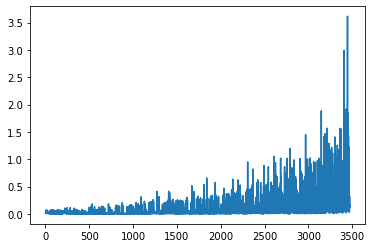

In [620]:
plt.plot(losses);

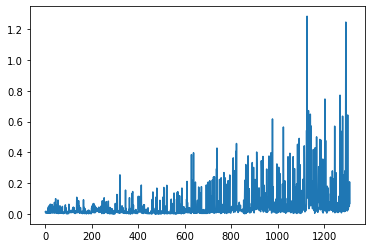

In [607]:
plt.plot(losses);

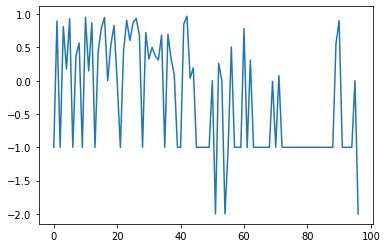

In [621]:
plt.plot(episode_rewards);

In [623]:
len(buffer)

4473

Let's examine our training samples

## Replay buffer check

Let's take replay buffer from the previous run and check it for anomalies.

In [624]:
# buffer is just a container of objects of ExperienceFirstLast 
# (https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L155)
# which just a namedtuple with fields: state, action, reward, last_state
final_good = []
final_bad = []
for s in buffer:
    if s.last_state is None:
        if s.reward > 0.2:
            final_good.append(s)
        elif s.reward < -0.2:
            final_bad.append(s)
print("Found %d final good states and %d final bad" % (len(final_good), len(final_bad)))

Found 33 final good states and 53 final bad


In [625]:
len(episode_rewards)

97

In [626]:
final_good_imgs = [get_obs_img(s.state, action=s.action) for s in final_good]
final_bad_imgs = [get_obs_img(s.state, action=s.action) for s in final_bad]

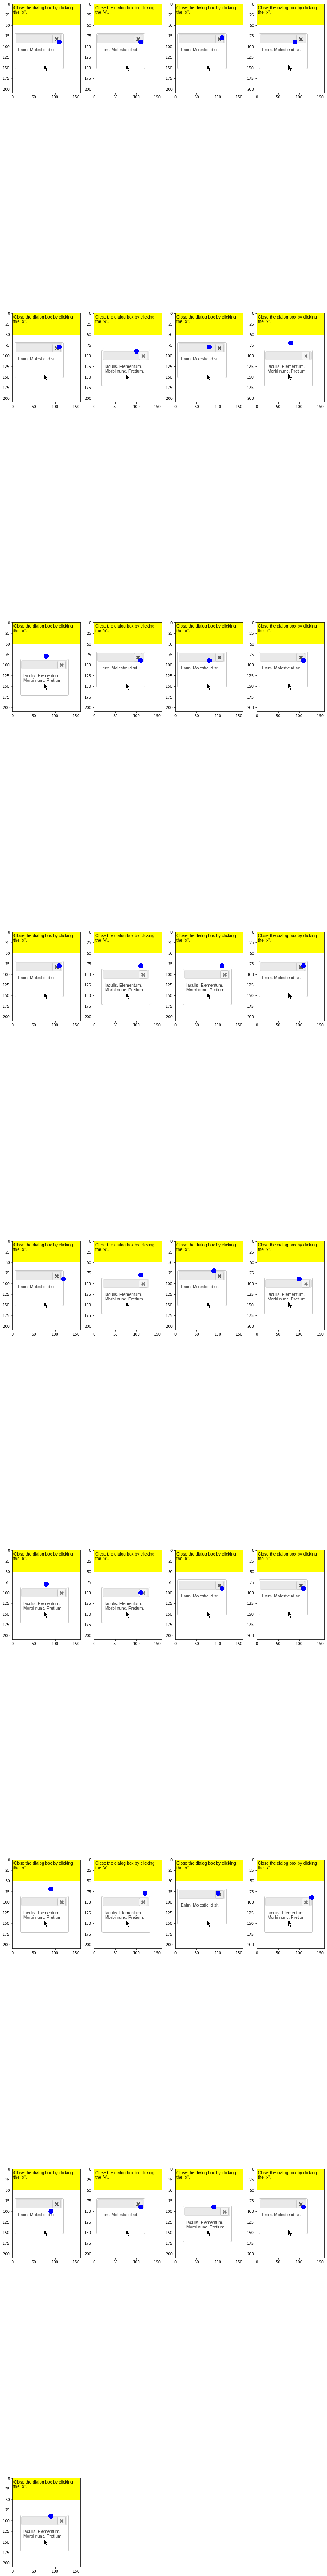

In [631]:
fig = plt.figure(figsize=(15, 150))

rows = 10
for i, img in enumerate(final_good_imgs, start=1):
    fig.add_subplot(rows, np.ceil(len(final_good_imgs)/rows), i)
    plt.imshow(img)
plt.show()

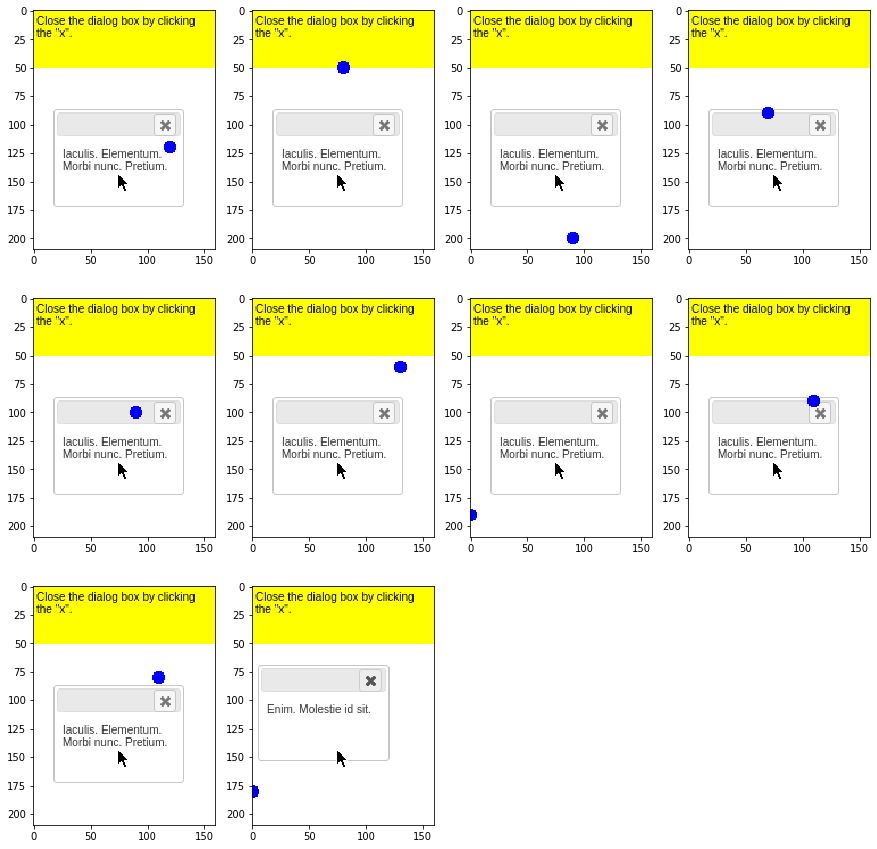

In [635]:
fig = plt.figure(figsize=(15, 15))

rows = 3
for i, img in enumerate(final_bad_imgs[:10], start=1):
    fig.add_subplot(rows, np.ceil(len(final_bad_imgs[:10])/rows), i)
    plt.imshow(img)
plt.show()

Oh. Conclusion: asynchronous nature of Universe and MiniWoB makes it fundamentally harder setup for simple DQN.

Possible approaches:
1. bandit-like setup (for this particular problem): we issue one single click and wait for episode to end.
2. POMDP setup: we should extend the observation space with history of clicks we've done.

In the next notebook we'll apply part of the first approach to our DQN version. You're free to experiment with pure-bandit methods for this problem or implement POMDP version (shouldn't be very complicated, one way of doing this could to pass the grid of clicked cells to the conv layer as extra "color" plane).

# Do not forget to stop container

In [462]:
env.close()

In [578]:
!./containers_run.sh

Starting container 1
e592c5a7f6b252f702ac88c09878f39cefea316096685b471414285a0f10a3ab


In [577]:
!./containers_stop.sh

"docker stop" requires at least 1 argument.
See 'docker stop --help'.

Usage:  docker stop [OPTIONS] CONTAINER [CONTAINER...]

Stop one or more running containers
